## Vehicle Detection Model with Image Processing Techniques

#### `Objectives`
1. Accurately detect and differentiate between vehicles and non-vehicles in a given input image or video stream.
2. Achieve a high level of precision and recall to minimize false positives and false negatives respectively.
3. Handle a variety of environmental conditions such as changes in lighting, weather, and road surface.
4. Identify different types of vehicles such as cars, trucks, buses, and motorcycles.
5. Perform in real-time or near real-time to enable real-time decision-making in autonomous driving or security applications.
6. Be scalable and adaptable to work with different camera resolutions, frame rates, and field of views.
7. Continuously learn and improve performance over time through feedback mechanisms and data retraining.
8. Enable integration with other systems such as navigation, control, and communication systems in autonomous driving applications.
9. Provide interpretable results and insights to aid human decision-making in security and traffic management applications.

#### `Motivation`
Creating a vehicle vs. non-vehicle detection machine learning model can be extremely useful in a variety of applications. For example, in the field of autonomous driving, it is important to accurately detect and differentiate between vehicles and non-vehicles on the road. This can help the vehicle make appropriate decisions and avoid collisions. Similarly, in the field of security, such a model can be used to detect vehicles in restricted areas or to track the movement of vehicles in a city. Furthermore, it can also be used in traffic analysis to monitor the flow of vehicles on a road or to optimize traffic management systems. Overall, a vehicle vs. non-vehicle detection model can have significant practical applications in various domains and can contribute to improving safety and efficiency in transportation and security.

#### `Structure of this Notebook`
[1. Set up the Environment and Import Packages](#section_id1)

[2. Import the Data](#section_id2)

[3. Pre-processing the Data](#section_id3)

[4. Building the Model](#section_id4)

[5. Evaluate the Models and Predictions](#section_id5)

### Step 1: Set-up the Environment and Import Packages <a id='section_id1'></a>

In [21]:
# standard
import pandas as pd
import numpy as np
import random
import os
import cv2
import warnings
import shutil
import gc
import pydot
import graphviz

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from skimage.transform import resize
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

random.seed(2)
%matplotlib inline

#warning hadle
warnings.filterwarnings("ignore")

### Step 2: Import data<a id='section_id2'></a>

#### `Data`

We will use a dataset available in [Kaggle](https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set/code). The data was preliminarily split into two sets: vehicles and non-vehicles. We have a total of 17,760 images for both vehicle and non-vehicle.

#### `Step 2.1: Importing the dataset`

In [2]:
maindir = "../1_vehicle_image_processing/data"
os.listdir(maindir)

['.ipynb_checkpoints', 'non-vehicles', 'vehicles']

In [3]:
vehicle_dir = "../1_vehicle_image_processing/data/vehicles"
nonvehicle_dir = "../1_vehicle_image_processing/data/non-vehicles"
vehicle = os.listdir(maindir+"/vehicles")
non_vehicle = os.listdir(maindir+"/non-vehicles")

# check dataset size
print(f"Number of Vehicle Images: {len(vehicle)}")
print(f"Number of Non-Vehicle Images: {len(non_vehicle)}")

# check the names of files
print(f"5 Names of Vehicle Images: {vehicle[:5]}")
print(f"5 Names of Non-Vehicle Images: {non_vehicle[:5]}")

Number of Vehicle Images: 8792
Number of Non-Vehicle Images: 8968
5 Names of Vehicle Images: ['1.png', '10.png', '1000.png', '1001.png', '1002.png']
5 Names of Non-Vehicle Images: ['extra1.png', 'extra10.png', 'extra100.png', 'extra1000.png', 'extra1001.png']


#### `Step 2.2: Image inspection`

Randomly selecting 5 images from each dataset to take a peak at what the images look like and plot them.

Sample of 5 images in data:


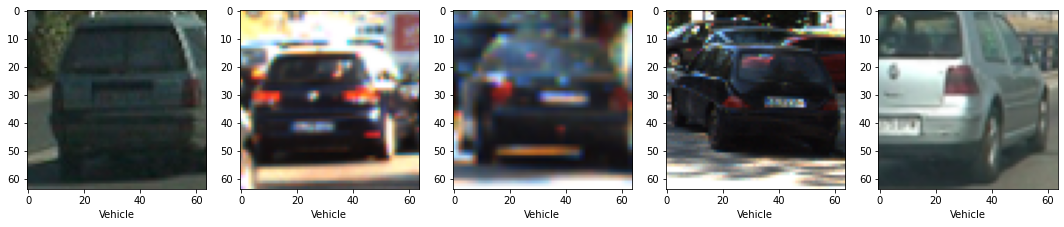

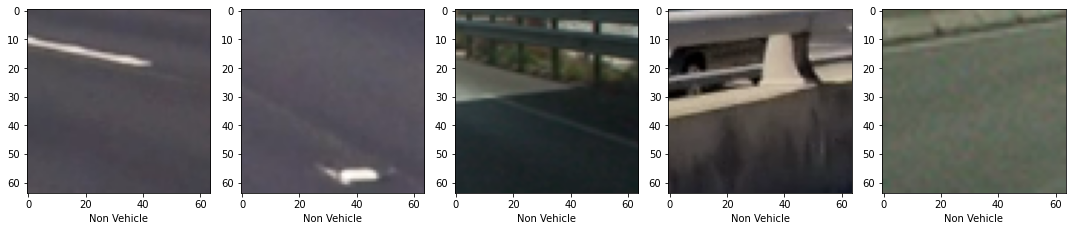

In [4]:
vehicle_img = np.random.choice(vehicle,5)
nonvehicle_img = np.random.choice(non_vehicle,5)

print('Sample of 5 images in data:')
plt.figure(figsize=(15,9))

for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread(vehicle_dir+'/'+vehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Vehicle")
    plt.tight_layout()
    plt.imshow(img)
plt.show()

plt.figure(figsize=(15,9)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread(nonvehicle_dir+'/'+nonvehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Non Vehicle")
    plt.imshow(img)
    plt.tight_layout()
plt.show()

### Step 3: Pre-processing the data <a id='section_id3'></a>

To start getting up the data before pushing through the models, we are creating dataframe that just contains the name of the file. We then convert the images into PIL object (Python Imaging Library) using ```load_img``` and then to NumPy array using ```img_to_array```.

#### `Step 3.1: Create a dataframe with appropriate labels`

In [5]:
# create a dataframe with original file names and 'vehicle' label
def create_df(src_dir):
    # Get list of all files in source directory
    all_files = os.listdir(src_dir)
    file_paths = [os.path.join(src_dir, file) for file in all_files]
    
    if src_dir == "../1_vehicle_image_processing/data/vehicles/":
        df = pd.DataFrame({'file_name': all_files, 'category': 'vehicle', 'file_path': file_paths, 'label': 1})
    else:
        df = pd.DataFrame({'file_name': all_files, 'category': 'non_vehicle', 'file_path': file_paths, 'label': 0})
    
    return df

In [6]:
# create a dataframe for vehicle directory
df_vehicles = create_df("../1_vehicle_image_processing/data/vehicles/")
df_nonvehicles = create_df("../1_vehicle_image_processing/data/non-vehicles/")
print('DataFrame for vehicles:\n', df_vehicles)
print('DataFrame for non-vehicles:\n', df_nonvehicles)

DataFrame for vehicles:
            file_name category  \
0              1.png  vehicle   
1             10.png  vehicle   
2           1000.png  vehicle   
3           1001.png  vehicle   
4           1002.png  vehicle   
...              ...      ...   
8787  right (95).png  vehicle   
8788  right (96).png  vehicle   
8789  right (97).png  vehicle   
8790  right (98).png  vehicle   
8791  right (99).png  vehicle   

                                              file_path  label  
0     ../1_vehicle_image_processing/data/vehicles/1.png      1  
1     ../1_vehicle_image_processing/data/vehicles/10...      1  
2     ../1_vehicle_image_processing/data/vehicles/10...      1  
3     ../1_vehicle_image_processing/data/vehicles/10...      1  
4     ../1_vehicle_image_processing/data/vehicles/10...      1  
...                                                 ...    ...  
8787  ../1_vehicle_image_processing/data/vehicles/ri...      1  
8788  ../1_vehicle_image_processing/data/vehicles/ri...   

#### `Step 3.2: Exploratory Data Analysis (EDA) to understand the distribution of the images`

shape of the DataFrame: (17760, 4)
shape of the vehicle DataFrame: (8792, 4)
shape of the non_vehicle DataFrame: (8968, 4)


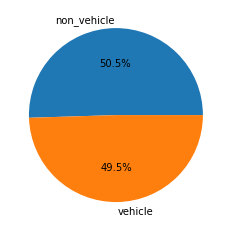

In [7]:
# create a plot to show the distribution of vehicle vs. non-vehicle images.
df = pd.concat([df_vehicles, df_nonvehicles], ignore_index=True)
print("shape of the DataFrame:", df.shape)
print("shape of the vehicle DataFrame:", df_vehicles.shape)
print("shape of the non_vehicle DataFrame:", df_nonvehicles.shape)
plt.pie(df["category"].value_counts(), labels=['non_vehicle','vehicle'], autopct='%1.1f%%')
plt.show()

#### `Step 3.2: Create a shuffled DataFrame and binary labels for vehicle (0) and non-vehicle (1)`

In [8]:
# shuffle the data using the concatenated DataFrame
df = df.sample(frac=1).reset_index()
df

,index,file_name,category,file_path,label
0,12989,extra5362.png,non_vehicle,../1_vehicle_image_processing/data/non-vehicle...,0
1,17204,image499.png,non_vehicle,../1_vehicle_image_processing/data/non-vehicle...,0
2,14716,image177.png,non_vehicle,../1_vehicle_image_processing/data/non-vehicle...,0
3,9834,extra2206.png,non_vehicle,../1_vehicle_image_processing/data/non-vehicle...,0
4,944,185.png,vehicle,../1_vehicle_image_processing/data/vehicles/18...,1
...,...,...,...,...,...
17755,5433,5892.png,vehicle,../1_vehicle_image_processing/data/vehicles/58...,1
17756,8488,right (423).png,vehicle,../1_vehicle_image_processing/data/vehicles/ri...,1
17757,12409,extra4780.png,non_vehicle,../1_vehicle_image_processing/data/non-vehicle...,0
17758,7434,left (670).png,vehicle,../1_vehicle_image_processing/data/vehicles/le...,1


#### `Step 3.3: Convert the images to a number array`

In [26]:
# converting the images to an array 
images = []
labels = df['label']
for path in df['file_path']:
    image = plt.imread(path)
    resizedImage = resize(image, (224, 224, 3))
    images.append(resizedImage)
images = np.array(images)
images = images/255

images[0]

array([[[0.00097459, 0.00089573, 0.00081774],
        [0.00095858, 0.0008769 , 0.0008077 ],
        [0.00096658, 0.00088632, 0.00081272],
        ...,
        [0.00090091, 0.00107659, 0.00110068],
        [0.00091032, 0.00109338, 0.00112264],
        [0.00089149, 0.0010598 , 0.00107871]],

       [[0.00114752, 0.00107463, 0.00100103],
        [0.00113026, 0.00105328, 0.00098847],
        [0.00113889, 0.00106396, 0.00099475],
        ...,
        [0.00092978, 0.00108004, 0.00109189],
        [0.00094045, 0.00109746, 0.00111386],
        [0.00091911, 0.00106262, 0.00106992]],

       [[0.00106105, 0.00098518, 0.00090938],
        [0.00104442, 0.00096509, 0.00089808],
        [0.00105273, 0.00097514, 0.00090373],
        ...,
        [0.00091535, 0.00107831, 0.00109628],
        [0.00092539, 0.00109542, 0.00111825],
        [0.0009053 , 0.00106121, 0.00107431]],

       ...,

       [[0.00093598, 0.00089965, 0.00094359],
        [0.00095262, 0.00090844, 0.00096117],
        [0.0009443 , 0

#### `Step 3.4: Split the dataset into train, validation and test`

In [27]:
# split the data into train and test datasets at 80-20 split respectively
X_train, X_test, y_train, y_test = train_test_split(images, labels.values, test_size=0.2, random_state=42)

# create a validation data set with X_train and y_train at 20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) #0.25*0.8 = 0.2

# print the sizes of the datasets
print("X_train shape:", X_train.shape,
    "\nX_test shape:", X_test.shape,
    "\nX_val shape:", X_val.shape,
    "\ny_train shape:", y_train.shape,
    "\ny_test shape:", y_test.shape,
    "\ny_val shape:", y_val.shape)                          

MemoryError: Unable to allocate 5.98 GiB for an array with shape (10656, 224, 224, 3) and data type float32

### Step 4: Building the Model<a id='section_id4'></a>

#### `Step 4.1: First iteration of the model development`

The objective is to build and train a CNN model to detect whether the image contains a shape of vehicle and I'm interested in exploring binary classification of 'vehicle' and 'non_vehicle'.

The architecture of our CNN model is as follows:

1. the model receives input images of size 224 x 224 x 3
2. the input data goes through a flattening layer
3. the flatten input goes through three connected layers, followed by a dropout layer

For the dropout layer, we set the probability of dropping input units during training to 0.3.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

img_shape=(224, 224, 3)

# create a sequential model
model = tf.keras.layers.Sequential()

# Add layers to the model
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape))
model(MaxPooling2D((2, 2)))

model(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model(MaxPooling2D((2, 2)))

model(Flatten())
model(Dense(256,activation = "relu"))
model.add(Dropout(0.1))
model(Dense(64,activation = "relu"))
model.add(Dropout(0.2))
model(Dense(2, activation = "softmax"))

# compile model 
# use the Adam optimizer, the most popular gradient-based optimization algorithm
# the loss function for our binary classification model is binary-crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [24]:
# fit the model with 10 epochs on the train set and validate on the validation set. 
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\sunny\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\sunny\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sunny\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\sunny\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\sunny\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\sunny\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "fc_1" is incompatible with the layer: expected axis -1 of input shape to have value 50176, but received input with shape (32, 150528)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
      • training=True
      • mask=None


In [ ]:
# plot the loss and accuracy for training and validation sets
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

#### `Step 4.2: Second iteration of the model development`

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# create a sequential model
model = tf.keras.layers.Sequential()

# Add layers to the model
model(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape))
model(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model(MaxPooling2D((2, 2)))
    
model(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model(MaxPooling2D((2, 2)))
    
model(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model(MaxPooling2D((2, 2)))
    
model(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model(MaxPooling2D((2, 2)))
    
model(Flatten())
model(Dense(256,activation = "relu"))
model.add(Dropout(0.1))
model(Dense(64,activation = "relu"))
model.add(Dropout(0.2))
model(Dense(2, activation = "softmax"))

# compile model 
# use the Adam optimizer, the most popular gradient-based optimization algorithm
# the loss function for our binary classification model is binary-crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 1)]     0         
                                                                 
 Flatten (Flatten)           (None, 50176)             0         
                                                                 
 fc_1 (Dense)                (None, 12544)             629420288 
                                                                 
 fc_2 (Dense)                (None, 3136)              39341120  
                                                                 
 fc_3 (Dense)                (None, 784)               2459408   
                                                                 
 Dropout (Dropout)           (None, 784)               0         
                                                                 
 fc_4 (Dense)                (None, 1)                 785   

In [ ]:
# fit the model with 10 epochs on the train set and validate on the validation set. 
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

In [ ]:
# plot the loss and accuracy for training and validation sets
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

### Step 5: Evaluate the Models and Predictions<a id='section_id5'></a>

In [ ]:
train_score = model.evaluate(X_test, y_train, verbose= 1)
valid_score = model.evaluate(X_val, y_val, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])